In [1]:
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from transformers import ViTForImageClassification
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define BiomarkerDataset
class BiomarkerDataset(Dataset):
    def __init__(self, label_file, transform=None, num_frames=0, use_clinical=True):
        self.data = pd.read_csv(label_file)
        self.transform = transform
        self.num_frames = num_frames
        self.use_clinical = use_clinical
        self.valid_indices = self.data[
            (self.data.iloc[:, 1] > num_frames) & (self.data.iloc[:, 1] < (50 - num_frames))
        ].index.tolist()

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        img_base_path = '/storage/ice1/shared/d-pace_community/makerspace-datasets/MEDICAL/OLIVES/OLIVES'
        index = self.valid_indices[idx]
        images = []

        for i in range(index - self.num_frames, index + self.num_frames + 1):
            img_path = img_base_path + self.data.iloc[i, 0]
            img = Image.open(img_path).convert("L")
            if self.transform is not None:
                img = self.transform(img)
            images.append(img.squeeze(0))

        images = torch.stack(images, dim=0)
        labels = torch.tensor(self.data.iloc[index, 2:18].astype(float), dtype=torch.float32)
        
        if self.use_clinical:
            clinical_data = torch.tensor(
                [self.data.iloc[index, 19], self.data.iloc[index, 20]], dtype=torch.float32
            )
        else:
            clinical_data = torch.tensor([], dtype=torch.float32)  # Empty clinical data

        return images, labels, clinical_data


# Define Multimodal Model
class MultimodalBiomarkerModel(nn.Module):
    def __init__(self, vision_model, clinical_input_size, num_biomarkers, use_clinical=True):
        super(MultimodalBiomarkerModel, self).__init__()
        self.vision_model = vision_model
        self.use_clinical = use_clinical
        if use_clinical:
            self.clinical_fc = nn.Linear(clinical_input_size, 128)
            self.combined_fc = nn.Linear(vision_model.config.hidden_size + 128, num_biomarkers)
        else:
            self.combined_fc = nn.Linear(vision_model.config.hidden_size, num_biomarkers)
        self.sigmoid = nn.Sigmoid()

    def forward(self, images, clinical_data):
        vision_features = self.vision_model(images).logits
        if self.use_clinical:
            clinical_features = torch.relu(self.clinical_fc(clinical_data))
            combined_features = torch.cat((vision_features, clinical_features), dim=1)
        else:
            combined_features = vision_features
        output = self.sigmoid(self.combined_fc(combined_features))
        return output


# Initialize Dataset and Transformers
image_size = 224
mean, std = 0.1706, 0.2112

# Train transform with data augmentation
train_transformer = transforms.Compose([
    transforms.Resize((image_size, image_size)),  # Resize to 224x224
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(degrees=10, fill=0),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

# Test transform without augmentation
test_transformer = transforms.Compose([
    transforms.Resize((image_size, image_size)),  # Resize to 224x224
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])


train_dataset_clinical = BiomarkerDataset('TEMP_BiomarkerLabel_train_data.csv', train_transformer, num_frames=1, use_clinical=True)
test_dataset_clinical = BiomarkerDataset('TEMP_BiomarkerLabel_test_data.csv', test_transformer, num_frames=1, use_clinical=True)

train_dataset_no_clinical = BiomarkerDataset('TEMP_BiomarkerLabel_train_data.csv', train_transformer, num_frames=1, use_clinical=False)
test_dataset_no_clinical = BiomarkerDataset('TEMP_BiomarkerLabel_test_data.csv', test_transformer, num_frames=1, use_clinical=False)

trainloader_clinical = DataLoader(train_dataset_clinical, batch_size=64, shuffle=True, drop_last=True)
testloader_clinical = DataLoader(test_dataset_clinical, batch_size=64, shuffle=False)

trainloader_no_clinical = DataLoader(train_dataset_no_clinical, batch_size=64, shuffle=True, drop_last=True)
testloader_no_clinical = DataLoader(test_dataset_no_clinical, batch_size=64, shuffle=False)

# Initialize Models
vision_model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224", num_labels=16, ignore_mismatched_sizes=True
)
vision_model.classifier = nn.Identity()

model_clinical = MultimodalBiomarkerModel(vision_model, clinical_input_size=2, num_biomarkers=16, use_clinical=True).to(device)
model_no_clinical = MultimodalBiomarkerModel(vision_model, clinical_input_size=2, num_biomarkers=16, use_clinical=False).to(device)


# Training Loop
def train_model(model, loader, optimizer, criterion, epochs):
    model.train()
    losses = []
    for epoch in range(epochs):
        total_loss = 0
        for images, labels, clinical_data in tqdm(loader):
            images, labels, clinical_data = (
                images.to(device),
                labels.to(device),
                clinical_data.to(device),
            )
            optimizer.zero_grad()
            outputs = model(images, clinical_data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(loader)
        losses.append(avg_loss)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")
    return losses


# Train vision-only model
optimizer_no_clinical = optim.Adam(model_no_clinical.parameters(), lr=1e-4)
criterion = nn.BCELoss()
train_losses_no_clinical = train_model(
    model_no_clinical, trainloader_no_clinical, optimizer_no_clinical, criterion, epochs=10
)

# Initialize multimodal model with pretrained vision weights
model_clinical.vision_model.load_state_dict(model_no_clinical.vision_model.state_dict())

# Freeze vision model weights
for param in model_clinical.vision_model.parameters():
    param.requires_grad = False

# Unfreeze fusion layers
for param in model_clinical.clinical_fc.parameters():
    param.requires_grad = True
for param in model_clinical.combined_fc.parameters():
    param.requires_grad = True

# Optimizer for fusion layers
optimizer_clinical_fusion = optim.Adam(
    list(model_clinical.clinical_fc.parameters()) + list(model_clinical.combined_fc.parameters()), lr=1e-4
)

# Train multimodal model (fusion layers only)
train_losses_clinical_fusion = train_model(
    model_clinical, trainloader_clinical, optimizer_clinical_fusion, criterion, epochs=10
)


/usr/local/lib/python3.10/dist-packages/torchvision/datapoints/__init__.py:14: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/__init__.py:64: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

Epoch 1/10, Loss: 0.2478


100%|██████████| 111/111 [01:06<00:00,  1.68it/s]


Epoch 2/10, Loss: 0.1773


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch 3/10, Loss: 0.1487


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch 4/10, Loss: 0.1277


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch 5/10, Loss: 0.1087


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch 6/10, Loss: 0.0984


100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch 7/10, Loss: 0.0880


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch 8/10, Loss: 0.0809


100%|██████████| 111/111 [01:08<00:00,  1.62it/s]


Epoch 9/10, Loss: 0.0759


100%|██████████| 111/111 [01:05<00:00,  1.68it/s]


Epoch 10/10, Loss: 0.0696


100%|██████████| 111/111 [01:01<00:00,  1.81it/s]


Epoch 1/10, Loss: 7.3524


100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch 2/10, Loss: 3.7631


100%|██████████| 111/111 [01:01<00:00,  1.81it/s]


Epoch 3/10, Loss: 3.7199


100%|██████████| 111/111 [01:00<00:00,  1.83it/s]


Epoch 4/10, Loss: 3.6921


100%|██████████| 111/111 [01:00<00:00,  1.84it/s]


Epoch 5/10, Loss: 3.6819


100%|██████████| 111/111 [01:00<00:00,  1.83it/s]


Epoch 6/10, Loss: 3.6773


100%|██████████| 111/111 [01:00<00:00,  1.83it/s]


Epoch 7/10, Loss: 3.6698


100%|██████████| 111/111 [01:00<00:00,  1.82it/s]


Epoch 8/10, Loss: 3.6674


100%|██████████| 111/111 [01:00<00:00,  1.83it/s]


Epoch 9/10, Loss: 3.6578


100%|██████████| 111/111 [01:00<00:00,  1.82it/s]

Epoch 10/10, Loss: 3.6663


In [1]:
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from transformers import ViTForImageClassification
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define BiomarkerDataset
class BiomarkerDataset(Dataset):
    def __init__(self, label_file, transform=None, num_frames=0, use_clinical=True):
        self.data = pd.read_csv(label_file)
        self.transform = transform
        self.num_frames = num_frames
        self.use_clinical = use_clinical
        self.valid_indices = self.data[
            (self.data.iloc[:, 1] > num_frames) & (self.data.iloc[:, 1] < (50 - num_frames))
        ].index.tolist()

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        img_base_path = '/storage/ice1/shared/d-pace_community/makerspace-datasets/MEDICAL/OLIVES/OLIVES'
        index = self.valid_indices[idx]
        images = []

        for i in range(index - self.num_frames, index + self.num_frames + 1):
            img_path = img_base_path + self.data.iloc[i, 0]
            img = Image.open(img_path).convert("L")
            if self.transform is not None:
                img = self.transform(img)
            images.append(img.squeeze(0))

        images = torch.stack(images, dim=0)
        labels = torch.tensor(self.data.iloc[index, 2:18].astype(float), dtype=torch.float32)
        
        if self.use_clinical:
            clinical_data = torch.tensor(
                [self.data.iloc[index, 19], self.data.iloc[index, 20]], dtype=torch.float32
            )
        else:
            clinical_data = torch.tensor([], dtype=torch.float32)  # Empty clinical data

        return images, labels, clinical_data


# Define Multimodal Model
class MultimodalBiomarkerModel(nn.Module):
    def __init__(self, vision_model, clinical_input_size, num_biomarkers, use_clinical=True):
        super(MultimodalBiomarkerModel, self).__init__()
        self.vision_model = vision_model
        self.use_clinical = use_clinical
        if use_clinical:
            self.clinical_fc = nn.Linear(clinical_input_size, 128)
            self.combined_fc = nn.Linear(vision_model.config.hidden_size + 128, num_biomarkers)
        else:
            self.combined_fc = nn.Linear(vision_model.config.hidden_size, num_biomarkers)
        self.sigmoid = nn.Sigmoid()

    def forward(self, images, clinical_data):
        vision_features = self.vision_model(images).logits
        if self.use_clinical:
            clinical_features = torch.relu(self.clinical_fc(clinical_data))
            combined_features = torch.cat((vision_features, clinical_features), dim=1)
        else:
            combined_features = vision_features
        output = self.sigmoid(self.combined_fc(combined_features))
        return output


# Initialize Dataset and Transformers
image_size = 224
mean, std = 0.1706, 0.2112

# Train transform with data augmentation
train_transformer = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(degrees=10, fill=0),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

# Test transform without augmentation
test_transformer = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

# Create Datasets and DataLoaders
train_dataset_clinical = BiomarkerDataset('TEMP_BiomarkerLabel_train_data.csv', train_transformer, num_frames=1, use_clinical=True)
test_dataset_clinical = BiomarkerDataset('TEMP_BiomarkerLabel_test_data.csv', test_transformer, num_frames=1, use_clinical=True)

train_dataset_no_clinical = BiomarkerDataset('TEMP_BiomarkerLabel_train_data.csv', train_transformer, num_frames=1, use_clinical=False)
test_dataset_no_clinical = BiomarkerDataset('TEMP_BiomarkerLabel_test_data.csv', test_transformer, num_frames=1, use_clinical=False)

trainloader_clinical = DataLoader(train_dataset_clinical, batch_size=64, shuffle=True, drop_last=True)
val_loader_clinical = DataLoader(test_dataset_clinical, batch_size=64, shuffle=False)

trainloader_no_clinical = DataLoader(train_dataset_no_clinical, batch_size=64, shuffle=True, drop_last=True)
val_loader_no_clinical = DataLoader(test_dataset_no_clinical, batch_size=64, shuffle=False)

# Initialize Models
vision_model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224", num_labels=16, ignore_mismatched_sizes=True
)
vision_model.classifier = nn.Identity()

model_clinical = MultimodalBiomarkerModel(vision_model, clinical_input_size=2, num_biomarkers=16, use_clinical=True).to(device)
model_no_clinical = MultimodalBiomarkerModel(vision_model, clinical_input_size=2, num_biomarkers=16, use_clinical=False).to(device)

# Modified Training Loop to Save Best Model Weights
def train_model_with_best_weights(model, train_loader, val_loader, optimizer, criterion, epochs, model_save_path):
    model.train()
    best_val_loss = float('inf')
    losses = []

    for epoch in range(epochs):
        # Training phase
        total_train_loss = 0
        for images, labels, clinical_data in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{epochs}"):
            images, labels, clinical_data = (
                images.to(device),
                labels.to(device),
                clinical_data.to(device),
            )
            optimizer.zero_grad()
            outputs = model(images, clinical_data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        losses.append(avg_train_loss)
        print(f"Epoch {epoch + 1}, Training Loss: {avg_train_loss:.4f}")

        # Validation phase
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for images, labels, clinical_data in val_loader:
                images, labels, clinical_data = (
                    images.to(device),
                    labels.to(device),
                    clinical_data.to(device),
                )
                outputs = model(images, clinical_data)
                val_loss = criterion(outputs, labels)
                total_val_loss += val_loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        print(f"Epoch {epoch + 1}, Validation Loss: {avg_val_loss:.4f}")

        # Save model if validation loss improves
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), model_save_path)
            print(f"Best model saved at Epoch {epoch + 1} with Validation Loss: {avg_val_loss:.4f}")

        model.train()

    return losses


# Optimizers and Training
criterion = nn.BCELoss()

'''
# Train Model Without Clinical Labels
optimizer_no_clinical = optim.Adam(model_no_clinical.parameters(), lr=1e-4)
model_no_clinical_save_path = "best_model_no_clinical.pth"
train_losses_no_clinical = train_model_with_best_weights(
    model_no_clinical,
    trainloader_no_clinical,
    val_loader_no_clinical,
    optimizer_no_clinical,
    criterion,
    epochs=10,
    model_save_path=model_no_clinical_save_path,
)

# Train Model With Clinical Labels
optimizer_clinical = optim.Adam(model_clinical.parameters(), lr=1e-4)
model_clinical_save_path = "best_model_clinical.pth"
train_losses_clinical = train_model_with_best_weights(
    model_clinical,
    trainloader_clinical,
    val_loader_clinical,
    optimizer_clinical,
    criterion,
    epochs=10,
    model_save_path=model_clinical_save_path,
)

print("Training completed. Best models saved as:")
print(f" - Without clinical labels: {model_no_clinical_save_path}")
print(f" - With clinical labels: {model_clinical_save_path}")'''


/usr/local/lib/python3.10/dist-packages/torchvision/datapoints/__init__.py:14: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/__init__.py:64: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

Epoch 1, Training Loss: 0.2463
Epoch 1, Validation Loss: 0.2433
Best model saved at Epoch 1 with Validation Loss: 0.2433


Training Epoch 2/10: 100%|██████████| 111/111 [01:06<00:00,  1.67it/s]


Epoch 2, Training Loss: 0.1809
Epoch 2, Validation Loss: 0.2298
Best model saved at Epoch 2 with Validation Loss: 0.2298


Training Epoch 3/10: 100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch 3, Training Loss: 0.1498
Epoch 3, Validation Loss: 0.2286
Best model saved at Epoch 3 with Validation Loss: 0.2286


Training Epoch 4/10: 100%|██████████| 111/111 [01:05<00:00,  1.68it/s]


Epoch 4, Training Loss: 0.1280
Epoch 4, Validation Loss: 0.2437


Training Epoch 5/10: 100%|██████████| 111/111 [01:05<00:00,  1.68it/s]


Epoch 5, Training Loss: 0.1119
Epoch 5, Validation Loss: 0.2307


Training Epoch 6/10: 100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch 6, Training Loss: 0.0988
Epoch 6, Validation Loss: 0.2367


Training Epoch 7/10: 100%|██████████| 111/111 [01:06<00:00,  1.66it/s]


Epoch 7, Training Loss: 0.0905
Epoch 7, Validation Loss: 0.2442


Training Epoch 8/10: 100%|██████████| 111/111 [01:06<00:00,  1.68it/s]


Epoch 8, Training Loss: 0.0818
Epoch 8, Validation Loss: 0.2563


Training Epoch 9/10: 100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch 9, Training Loss: 0.0765
Epoch 9, Validation Loss: 0.2596


Training Epoch 10/10: 100%|██████████| 111/111 [01:05<00:00,  1.70it/s]


Epoch 10, Training Loss: 0.0724
Epoch 10, Validation Loss: 0.2698


Training Epoch 1/10: 100%|██████████| 111/111 [01:06<00:00,  1.68it/s]


Epoch 1, Training Loss: 0.5583
Epoch 1, Validation Loss: 0.2272
Best model saved at Epoch 1 with Validation Loss: 0.2272


Training Epoch 2/10: 100%|██████████| 111/111 [01:05<00:00,  1.68it/s]


Epoch 2, Training Loss: 0.1110
Epoch 2, Validation Loss: 0.2643


Training Epoch 3/10: 100%|██████████| 111/111 [01:06<00:00,  1.68it/s]


Epoch 3, Training Loss: 0.0891
Epoch 3, Validation Loss: 0.2539


Training Epoch 4/10: 100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch 4, Training Loss: 0.0769
Epoch 4, Validation Loss: 0.2645


Training Epoch 5/10: 100%|██████████| 111/111 [01:06<00:00,  1.68it/s]


Epoch 5, Training Loss: 0.0712
Epoch 5, Validation Loss: 0.2929


Training Epoch 6/10: 100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch 6, Training Loss: 0.0675
Epoch 6, Validation Loss: 0.3372


Training Epoch 7/10: 100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch 7, Training Loss: 0.0615
Epoch 7, Validation Loss: 0.3305


Training Epoch 8/10: 100%|██████████| 111/111 [01:05<00:00,  1.68it/s]


Epoch 8, Training Loss: 0.0580
Epoch 8, Validation Loss: 0.3145


Training Epoch 9/10: 100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch 9, Training Loss: 0.0533
Epoch 9, Validation Loss: 0.3185


Training Epoch 10/10: 100%|██████████| 111/111 [01:05<00:00,  1.69it/s]


Epoch 10, Training Loss: 0.0517
Epoch 10, Validation Loss: 0.3153
Training completed. Best models saved as:
 - Without clinical labels: best_model_no_clinical.pth
 - With clinical labels: best_model_clinical.pth


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([16]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([16, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Evaluating Model with Clinical Data...
Evaluating Scan-Level Metrics...
Plotting Combined Confusion Matrix for Scan-Level Predictions...


<Figure size 600x400 with 0 Axes>

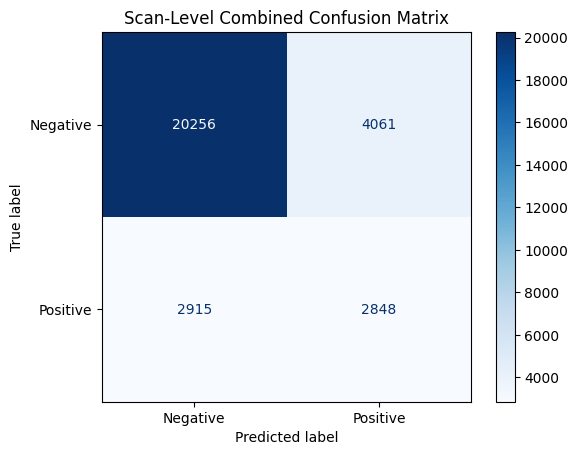

                           Biomarker       AUC  Precision    Recall        F1
0                            Atrophy  0.636202   0.000000  0.000000  0.000000
1                   Disruption of EZ  0.537964   0.000000  0.000000  0.000000
2                               DRIL  0.825431   0.000000  0.000000  0.000000
3                     IR hemorrhages  0.738914   0.000000  0.000000  0.000000
4                             IR HRF  0.299159   0.650053  0.424809  0.513831
5   Partially attached vitreous face  0.375261   0.375668  0.753351  0.501338
6       Fully attached vitreous face  0.448241   0.925000  0.077895  0.143689
7       Preretinal tissue/hemorrhage  0.153732   0.000000  0.000000  0.000000
8                    Vitreous debris  0.428737   0.000000  0.000000  0.000000
9                                VMT  0.806429   0.000000  0.000000  0.000000
10                            DRT/ME  0.630099   0.343085  1.000000  0.510891
11                       Fluid (IRF)  0.360084   0.507447  1.000

<Figure size 600x400 with 0 Axes>

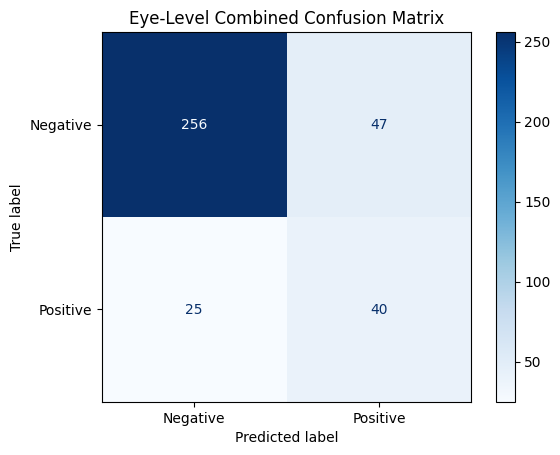

                           Biomarker       AUC  Precision    Recall        F1
0                            Atrophy  0.545455   0.000000  0.000000  0.000000
1                   Disruption of EZ       NaN   0.000000  0.000000  0.000000
2                               DRIL       NaN   0.000000  0.000000  0.000000
3                     IR hemorrhages       NaN   0.000000  0.000000  0.000000
4                             IR HRF  0.523810   0.916667  0.523810  0.666667
5   Partially attached vitreous face  0.261905   0.400000  0.888889  0.551724
6       Fully attached vitreous face  0.400000   1.000000  0.200000  0.333333
7       Preretinal tissue/hemorrhage       NaN   0.000000  0.000000  0.000000
8                    Vitreous debris  0.388889   0.000000  0.000000  0.000000
9                                VMT       NaN   0.000000  0.000000  0.000000
10                            DRT/ME  0.375000   0.304348  1.000000  0.466667
11                       Fluid (IRF)  0.227273   0.521739  1.000

<Figure size 600x400 with 0 Axes>

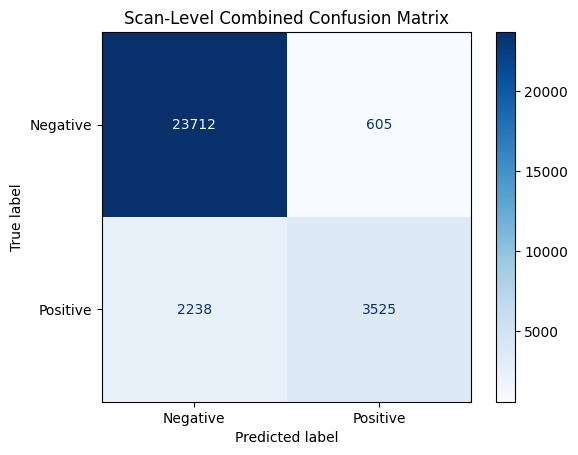

                           Biomarker       AUC  Precision    Recall        F1
0                            Atrophy  0.758380   0.000000  0.000000  0.000000
1                   Disruption of EZ  0.611134   0.000000  0.000000  0.000000
2                               DRIL  0.474694   0.000000  0.000000  0.000000
3                     IR hemorrhages  0.811457   0.000000  0.000000  0.000000
4                             IR HRF  0.823240   0.902801  0.759529  0.824991
5   Partially attached vitreous face  0.796446   0.703125  0.542895  0.612708
6       Fully attached vitreous face  0.872329   0.826793  0.643158  0.723505
7       Preretinal tissue/hemorrhage  0.789815   0.818182  0.086538  0.156522
8                    Vitreous debris  0.757616   0.706897  0.405941  0.515723
9                                VMT  0.967857   0.000000  0.000000  0.000000
10                            DRT/ME  0.963150   0.952015  0.768992  0.850772
11                       Fluid (IRF)  0.908746   0.932394  0.693

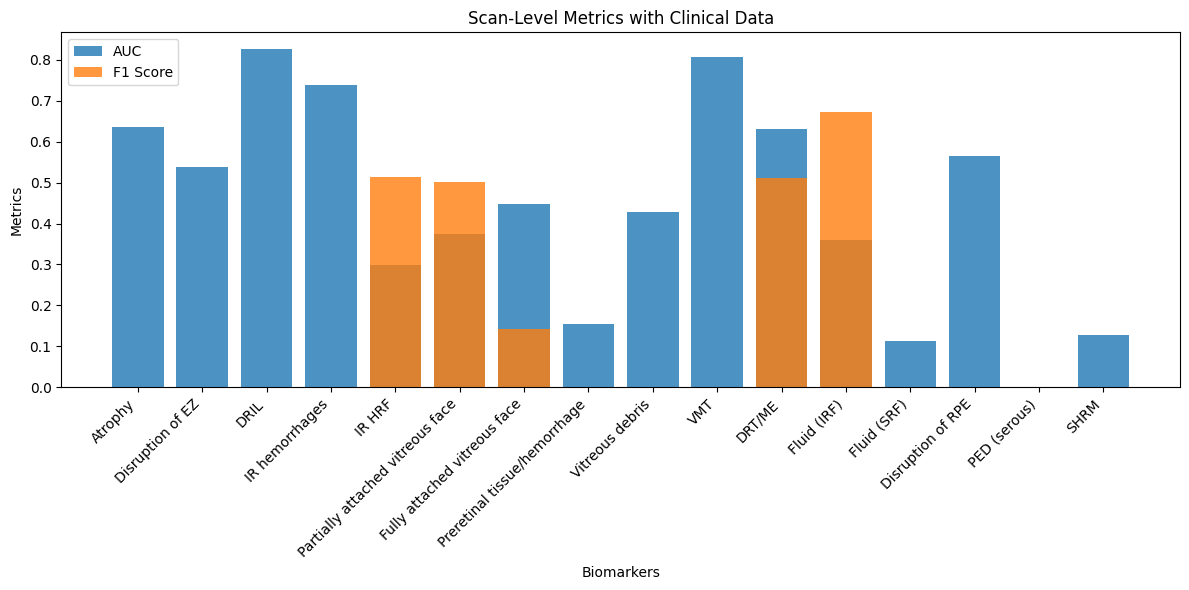

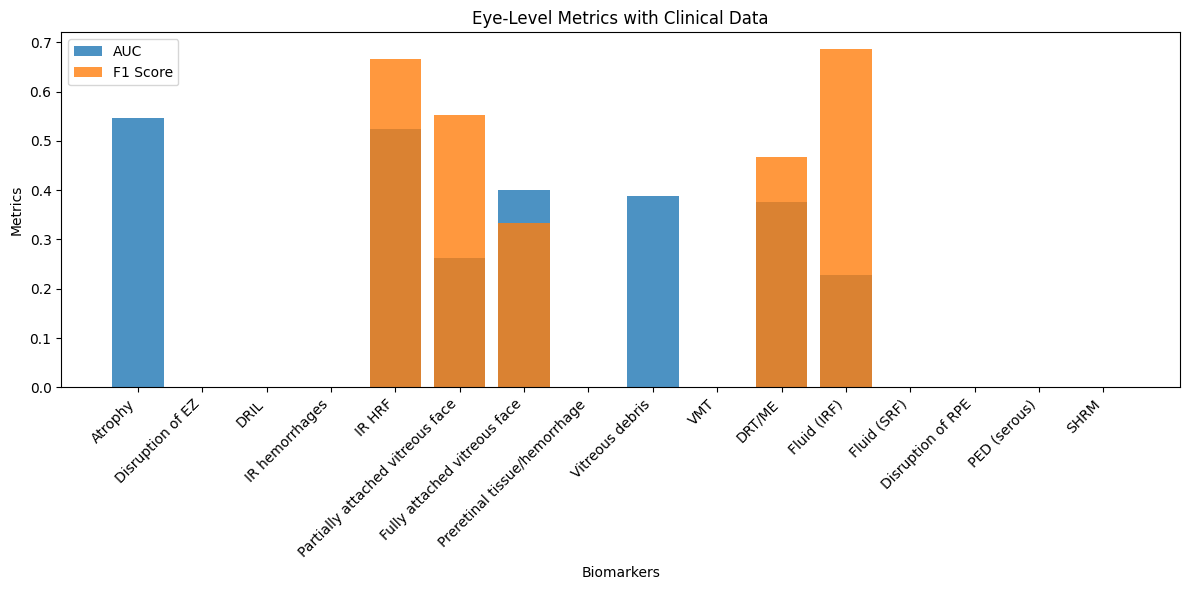

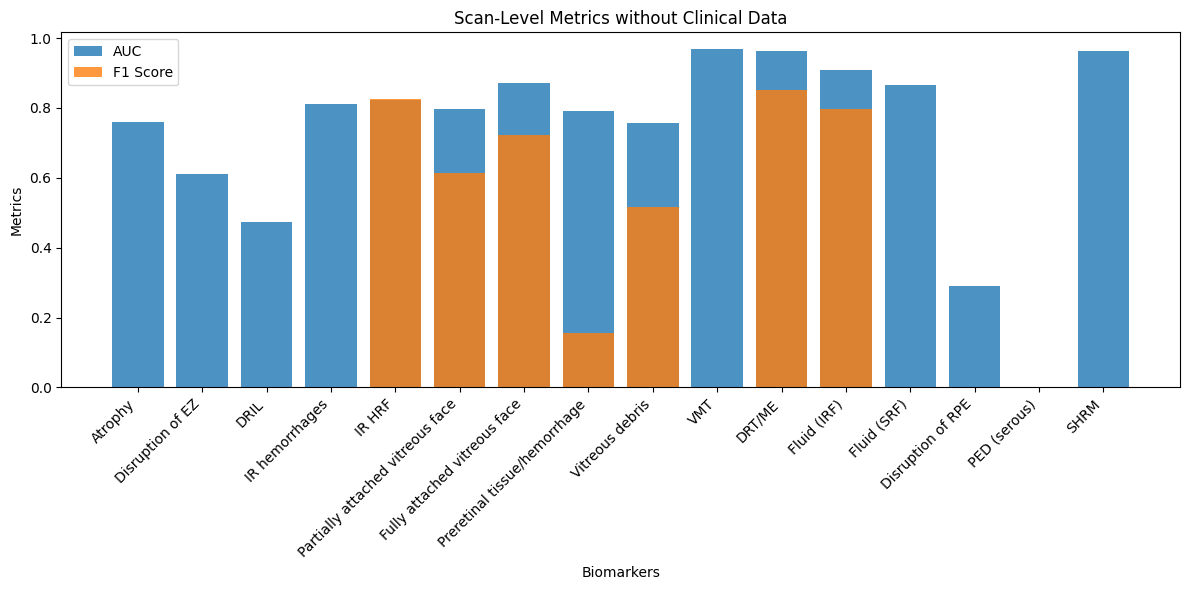


Ablation Study Results:
Clinical Data Impact on Biomarker Detection
                           Biomarker  F1 with Clinical Data  \
0                            Atrophy               0.000000   
1                   Disruption of EZ               0.000000   
2                               DRIL               0.000000   
3                     IR hemorrhages               0.000000   
4                             IR HRF               0.513831   
5   Partially attached vitreous face               0.501338   
6       Fully attached vitreous face               0.143689   
7       Preretinal tissue/hemorrhage               0.000000   
8                    Vitreous debris               0.000000   
9                                VMT               0.000000   
10                            DRT/ME               0.510891   
11                       Fluid (IRF)               0.673253   
12                       Fluid (SRF)               0.000000   
13                 Disruption of RPE             

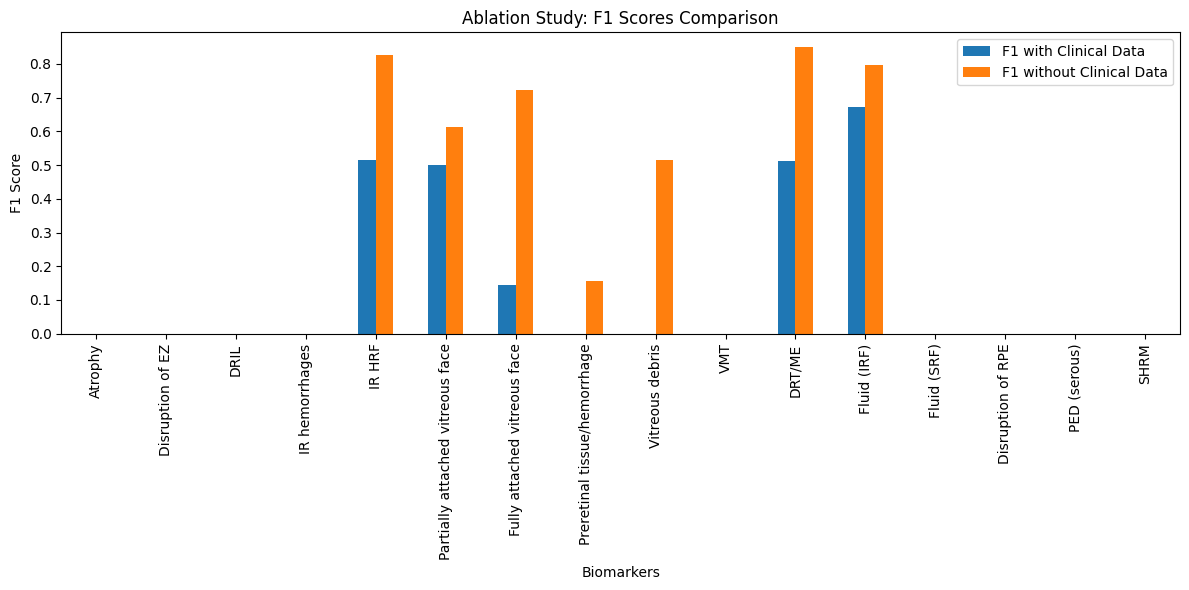

In [4]:
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from transformers import ViTForImageClassification
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from tqdm import tqdm
import matplotlib.pyplot as plt



# Create Datasets and DataLoaders
train_dataset_clinical = BiomarkerDataset('TEMP_BiomarkerLabel_train_data.csv', train_transformer, num_frames=1, use_clinical=True)
test_dataset_clinical = BiomarkerDataset('TEMP_BiomarkerLabel_test_data.csv', test_transformer, num_frames=1, use_clinical=True)

train_dataset_no_clinical = BiomarkerDataset('TEMP_BiomarkerLabel_train_data.csv', train_transformer, num_frames=1, use_clinical=False)
test_dataset_no_clinical = BiomarkerDataset('TEMP_BiomarkerLabel_test_data.csv', test_transformer, num_frames=1, use_clinical=False)

trainloader_clinical = DataLoader(train_dataset_clinical, batch_size=64, shuffle=True, drop_last=True)
testloader_clinical = DataLoader(test_dataset_clinical, batch_size=64, shuffle=False)

trainloader_no_clinical = DataLoader(train_dataset_no_clinical, batch_size=64, shuffle=True, drop_last=True)
testloader_no_clinical = DataLoader(test_dataset_no_clinical, batch_size=64, shuffle=False)


# Evaluation Function
def evaluate_model(model, loader, labels):
    """
    Evaluate the model and calculate metrics at the scan level.
    """
    model.eval()
    y_true, y_pred, eye_ids = [], [], []
    with torch.no_grad():
        for images, labels, clinical_data in loader:
            images, labels, clinical_data = (
                images.to(device),
                labels.to(device),
                clinical_data.to(device),
            )
            outputs = model(images, clinical_data)
            y_true.append(labels.cpu().numpy())
            y_pred.append(outputs.cpu().numpy())
            if clinical_data.size(1) > 0:  # Ensure Eye_ID exists
                eye_ids.append(clinical_data[:, 0].cpu().numpy())
            else:
                eye_ids.append([])  # No Eye_ID if no clinical data
    return np.vstack(y_true), np.vstack(y_pred), np.concatenate(eye_ids)

# Aggregation Function for Eye-Level Metrics
def aggregate_by_eye(y_true, y_pred, eye_ids):
    """
    Aggregate predictions and labels at the eye level.
    """
    unique_eye_ids = np.unique(eye_ids)
    eye_level_true = []
    eye_level_pred = []
    for eye_id in unique_eye_ids:
        mask = eye_ids == eye_id
        eye_level_true.append(y_true[mask].mean(axis=0))
        eye_level_pred.append(y_pred[mask].mean(axis=0))
    return np.array(eye_level_true), np.array(eye_level_pred)

from sklearn.metrics import roc_auc_score, classification_report

def compute_metrics(y_true, y_pred, labels):
    """
    Compute classification metrics for each biomarker.
    Args:
        y_true (ndarray or Tensor): True labels.
        y_pred (ndarray or Tensor): Predicted probabilities.
        labels (list): Biomarker names.
    Returns:
        metrics_df (DataFrame): DataFrame with per-biomarker metrics.
    """
    # Ensure tensors are moved to CPU and converted to NumPy
    if isinstance(y_true, torch.Tensor):
        y_true = y_true.cpu().numpy()
    if isinstance(y_pred, torch.Tensor):
        y_pred = y_pred.cpu().numpy()

    # Threshold y_true to ensure binary values
    y_true = (y_true > 0.5).astype(int)

    num_biomarkers = min(len(labels), y_true.shape[1])
    metrics = {"Biomarker": [], "AUC": [], "Precision": [], "Recall": [], "F1": []}

    for i in range(num_biomarkers):
        label = labels[i]

        # Check if y_true contains both classes
        if len(np.unique(y_true[:, i])) < 2:
            # Skip AUC calculation for constant labels
            metrics["Biomarker"].append(label)
            metrics["AUC"].append(None)  # Undefined AUC
            metrics["Precision"].append(0.0)
            metrics["Recall"].append(0.0)
            metrics["F1"].append(0.0)
            continue

        # Calculate metrics
        auc = roc_auc_score(y_true[:, i], y_pred[:, i])
        report = classification_report(
            y_true[:, i], (y_pred[:, i] > 0.5).astype(int), output_dict=True, zero_division=0
        )
        metrics["Biomarker"].append(label)
        metrics["AUC"].append(auc)
        metrics["Precision"].append(report["1"]["precision"])
        metrics["Recall"].append(report["1"]["recall"])
        metrics["F1"].append(report["1"]["f1-score"])
    return pd.DataFrame(metrics)

# Plotting Metrics
def plot_metrics(metrics_df, title):
    """
    Plot metrics as bar plots.
    """
    plt.figure(figsize=(12, 6))
    x = range(len(metrics_df))
    plt.bar(x, metrics_df["AUC"], label="AUC", alpha=0.8)
    plt.bar(x, metrics_df["F1"], label="F1 Score", alpha=0.8)
    plt.xticks(x, metrics_df["Biomarker"], rotation=45, ha="right")
    plt.xlabel("Biomarkers")
    plt.ylabel("Metrics")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()
    

# Plot ROC-AUC Curves
def plot_roc_auc_curves(y_true, y_pred, labels):
    plt.figure(figsize=(12, 8))
    for i, label in enumerate(labels):
        if len(np.unique(y_true[:, i])) < 2:
            continue  # Skip biomarkers with no positive samples
        fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
        plt.plot(fpr, tpr, label=f"{label} (AUC = {auc(fpr, tpr):.2f})")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC-AUC Curves")
    plt.legend()
    plt.show()


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Biomarker Labels
labels = [
    "Atrophy", "Disruption of EZ", "DRIL", "IR hemorrhages", "IR HRF",
    "Partially attached vitreous face", "Fully attached vitreous face",
    "Preretinal tissue/hemorrhage", "Vitreous debris", "VMT","DRT/ME", "Fluid (IRF)","Fluid (SRF)", "Disruption of RPE",
     "PED (serous)", "SHRM"
]

# Function to compute and plot a single confusion matrix for all biomarkers
def plot_combined_confusion_matrix(y_true, y_pred, title="Combined Confusion Matrix"):
    """
    Create and plot a single confusion matrix for all biomarkers.
    Args:
        y_true (ndarray): Ground truth binary labels for all biomarkers.
        y_pred (ndarray): Predicted probabilities for all biomarkers.
        title (str): Title for the confusion matrix plot.
    """
    # Flatten all biomarkers into a single dimension for combined confusion matrix
    y_true_combined = (y_true > 0.5).astype(int).ravel()  # Ensure binary labels
    y_pred_combined = (y_pred > 0.5).astype(int).ravel()  # Threshold predictions

    # Compute confusion matrix
    combined_matrix = confusion_matrix(y_true_combined, y_pred_combined)

    # Plot the confusion matrix
    plt.figure(figsize=(6, 4))
    disp = ConfusionMatrixDisplay(confusion_matrix=combined_matrix, display_labels=["Negative", "Positive"])
    disp.plot(cmap="Blues", values_format="d")
    plt.title(title)
    plt.show()


# Update the evaluation function to include combined confusion matrix
# Evaluate and Aggregate Results
def evaluate_with_eye_aggregation(model, loader, labels):
    """
    Evaluate model performance with and without eye-level aggregation.
    """
    print("Evaluating Scan-Level Metrics...")
    y_true, y_pred, eye_ids = evaluate_model(model, loader, labels)

    # Compute combined confusion matrix for scan-level predictions
    print("Plotting Combined Confusion Matrix for Scan-Level Predictions...")
    plot_combined_confusion_matrix(y_true, y_pred, "Scan-Level Combined Confusion Matrix")

    # Scan-Level Metrics
    scan_metrics = compute_metrics(y_true, y_pred, labels)
    print(scan_metrics)

    # Eye-Level Metrics
    eye_metrics = None
    if len(eye_ids) > 0:
        print("Evaluating Eye-Level Metrics...")
        eye_true, eye_pred = aggregate_by_eye(y_true, y_pred, eye_ids)

        # Compute combined confusion matrix for eye-level predictions
        print("Plotting Combined Confusion Matrix for Eye-Level Predictions...")
        plot_combined_confusion_matrix(eye_true, eye_pred, "Eye-Level Combined Confusion Matrix")

        eye_metrics = compute_metrics(eye_true, eye_pred, labels)
        print(eye_metrics)

    return scan_metrics, eye_metrics


# Recreate models
vision_model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224", num_labels=16, ignore_mismatched_sizes=True
)
vision_model.classifier = nn.Identity()

model_clinical = MultimodalBiomarkerModel(vision_model, clinical_input_size=2, num_biomarkers=16, use_clinical=True).to(device)
model_no_clinical = MultimodalBiomarkerModel(vision_model, clinical_input_size=2, num_biomarkers=16, use_clinical=False).to(device)

# Load weights
model_clinical.load_state_dict(torch.load("best_model_clinical.pth"))
model_no_clinical.load_state_dict(torch.load("best_model_no_clinical.pth"))

# Set evaluation mode
model_clinical.eval()
model_no_clinical.eval()

# Evaluate models
print("Evaluating Model with Clinical Data...")
scan_metrics_clinical, eye_metrics_clinical = evaluate_with_eye_aggregation(
    model_clinical, testloader_clinical, labels
)

print("Evaluating Model without Clinical Data...")
scan_metrics_no_clinical, eye_metrics_no_clinical = evaluate_with_eye_aggregation(
    model_no_clinical, testloader_no_clinical, labels
)

# Plot results
plot_metrics(scan_metrics_clinical, "Scan-Level Metrics with Clinical Data")
if eye_metrics_clinical is not None:
    plot_metrics(eye_metrics_clinical, "Eye-Level Metrics with Clinical Data")

plot_metrics(scan_metrics_no_clinical, "Scan-Level Metrics without Clinical Data")
if eye_metrics_no_clinical is not None:
    plot_metrics(eye_metrics_no_clinical, "Eye-Level Metrics without Clinical Data")

# Ablation Study
print("\nAblation Study Results:")
print("Clinical Data Impact on Biomarker Detection")
comparison = pd.DataFrame({
    "Biomarker": labels,
    "F1 with Clinical Data": scan_metrics_clinical["F1"],
    "F1 without Clinical Data": scan_metrics_no_clinical["F1"],
})
print(comparison)
comparison.plot(x="Biomarker", kind="bar", figsize=(12, 6), title="Ablation Study: F1 Scores Comparison")
plt.xlabel("Biomarkers")
plt.ylabel("F1 Score")
plt.tight_layout()
plt.show()

Evaluating Model with Clinical Data...
Evaluating Model without Clinical Data...
Visualizing biomarker correlations with clinical data...


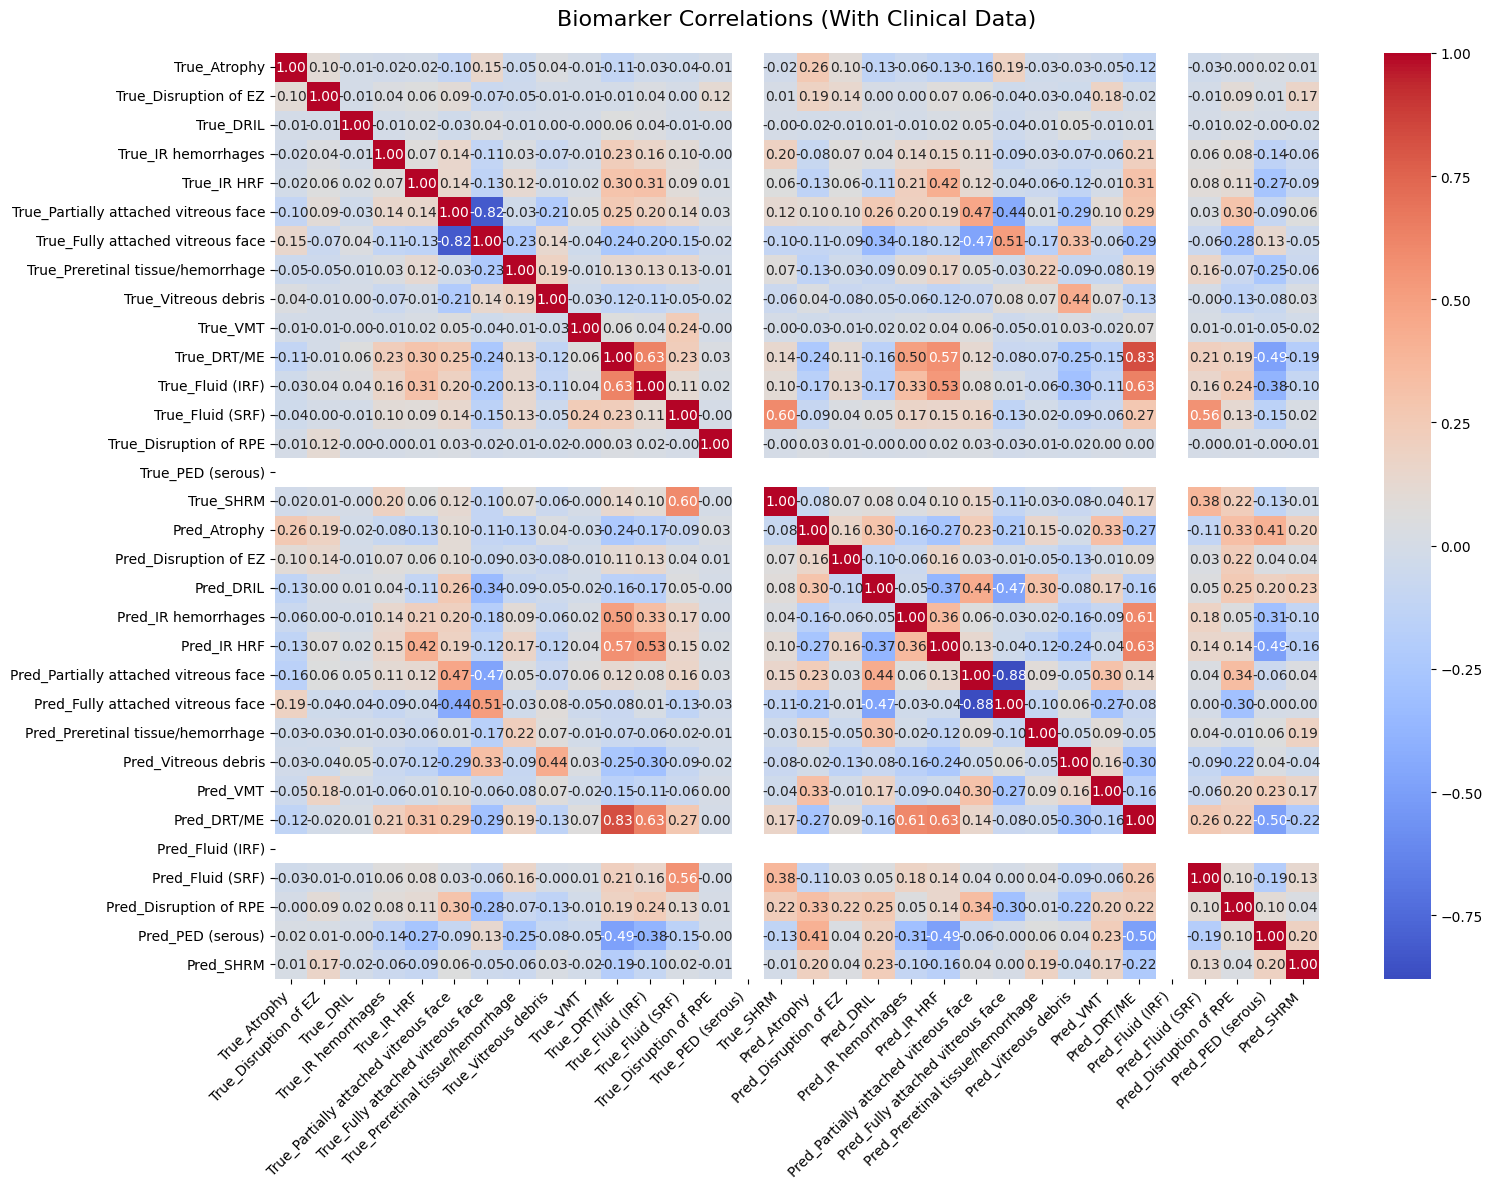

Visualizing biomarker correlations without clinical data...


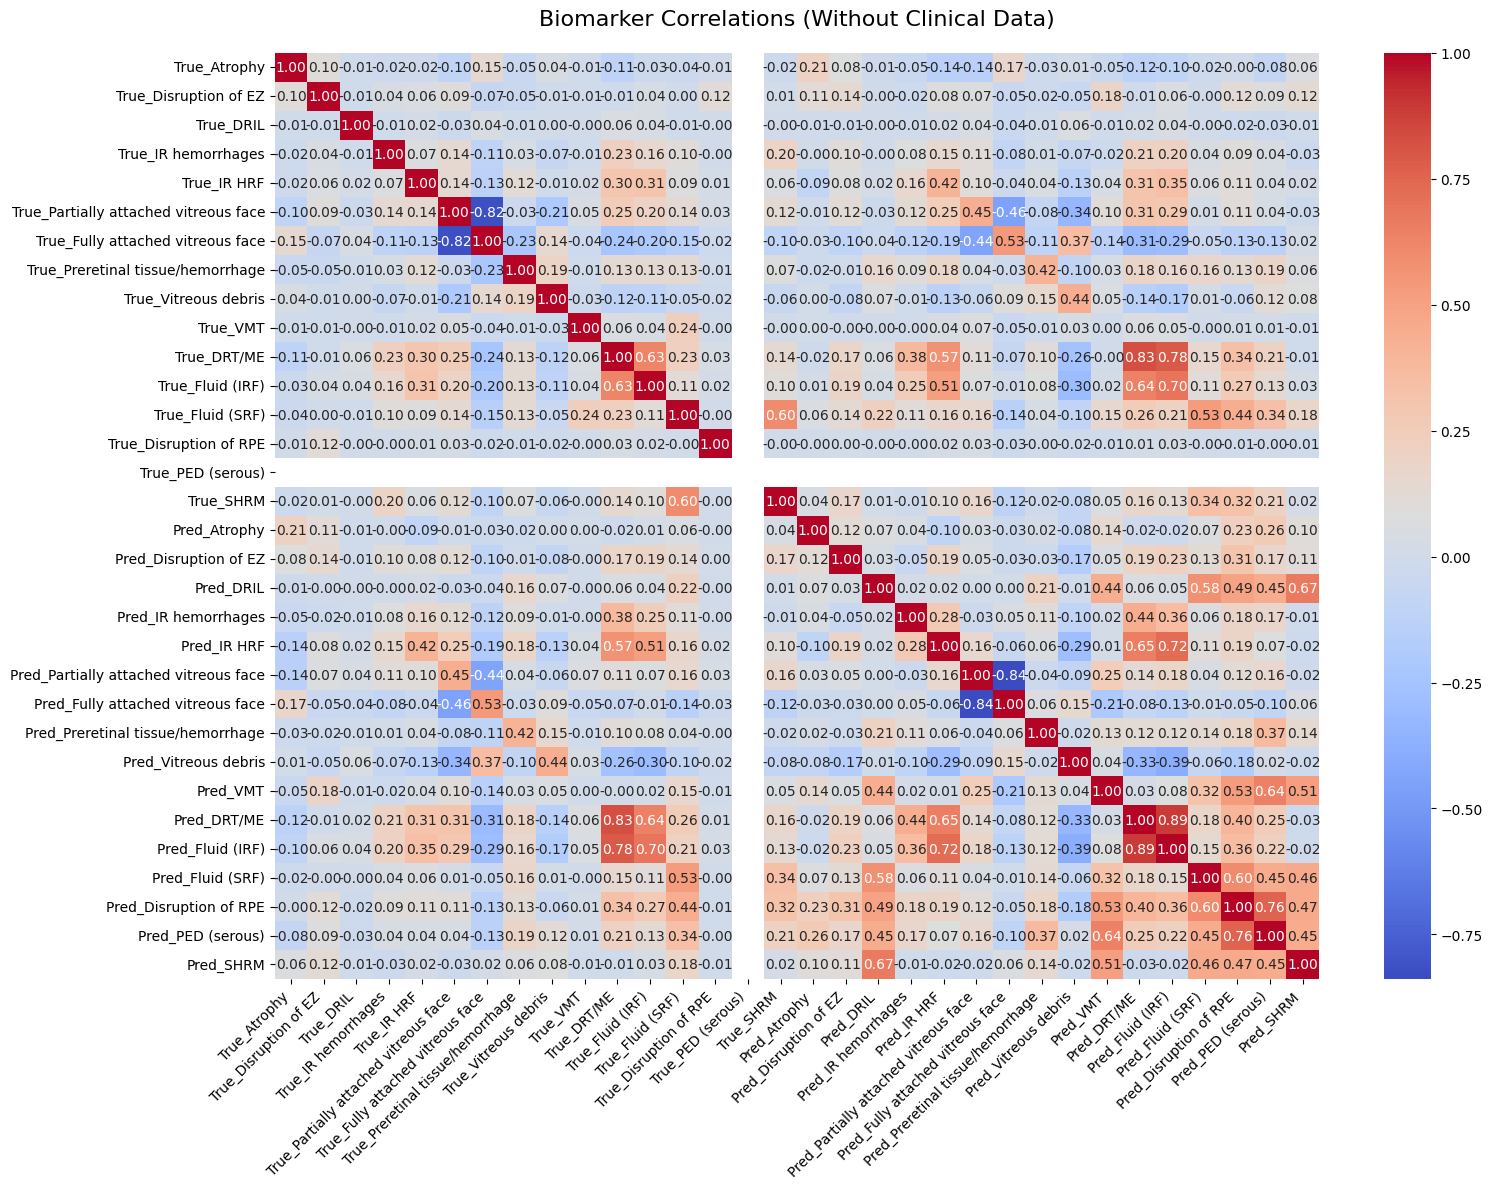

In [3]:
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

def plot_biomarker_correlations(y_true, y_pred, labels, title):
    """
    Visualize biomarker correlations using ground truth and predictions.
    Args:
        y_true (ndarray): Ground truth labels (binary).
        y_pred (ndarray): Predicted probabilities.
        labels (list): Biomarker names.
        title (str): Title for the correlation matrix plot.
    """
    # Create DataFrames for true and predicted values
    true_df = pd.DataFrame(y_true, columns=[f"True_{label}" for label in labels])
    pred_df = pd.DataFrame(y_pred, columns=[f"Pred_{label}" for label in labels])
    
    # Concatenate the true and predicted data
    combined_df = pd.concat([true_df, pred_df], axis=1)

    # Compute the correlation matrix
    corr_matrix = combined_df.corr()

    # Set up the matplotlib figure
    plt.figure(figsize=(16, 12))

    # Draw the heatmap
    sns.heatmap(
        corr_matrix,
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        cbar=True,
        annot_kws={"size": 10},
        xticklabels=corr_matrix.columns,
        yticklabels=corr_matrix.columns
    )

    # Improve layout and appearance
    plt.title(title, fontsize=16, pad=20)
    plt.xticks(fontsize=10, rotation=45, ha="right")
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()


# Step 1: Evaluate the model with clinical data
print("Evaluating Model with Clinical Data...")
y_true_clinical, y_pred_clinical, _ = evaluate_model(model_clinical, testloader_clinical, labels)

# Step 2: Evaluate the model without clinical data
print("Evaluating Model without Clinical Data...")
y_true_no_clinical, y_pred_no_clinical, _ = evaluate_model(model_no_clinical, testloader_no_clinical, labels)

# Step 3: Visualize biomarker correlations for clinical data
print("Visualizing biomarker correlations with clinical data...")
plot_biomarker_correlations(
    y_true_clinical, y_pred_clinical, labels, title="Biomarker Correlations (With Clinical Data)"
)

# Step 4: Visualize biomarker correlations for vision-only model
print("Visualizing biomarker correlations without clinical data...")
plot_biomarker_correlations(
    y_true_no_clinical, y_pred_no_clinical, labels, title="Biomarker Correlations (Without Clinical Data)"
)

In [5]:
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from transformers import ViTForImageClassification
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define BiomarkerDataset
class BiomarkerDataset(Dataset):
    def __init__(self, label_file, transform=None, num_frames=0, use_clinical=True):
        self.data = pd.read_csv(label_file)
        self.transform = transform
        self.num_frames = num_frames
        self.use_clinical = use_clinical
        self.valid_indices = self.data[
            (self.data.iloc[:, 1] > num_frames) & (self.data.iloc[:, 1] < (50 - num_frames))
        ].index.tolist()

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        img_base_path = '/storage/ice1/shared/d-pace_community/makerspace-datasets/MEDICAL/OLIVES/OLIVES'
        index = self.valid_indices[idx]
        images = []

        for i in range(index - self.num_frames, index + self.num_frames + 1):
            img_path = img_base_path + self.data.iloc[i, 0]
            img = Image.open(img_path).convert("L")
            if self.transform is not None:
                img = self.transform(img)
            images.append(img.squeeze(0))

        images = torch.stack(images, dim=0)
        labels = torch.tensor(self.data.iloc[index, 2:18].astype(float), dtype=torch.float32)
        
        if self.use_clinical:
            clinical_data = torch.tensor(
                [self.data.iloc[index, 19], self.data.iloc[index, 20]], dtype=torch.float32
            )
        else:
            clinical_data = torch.tensor([], dtype=torch.float32)  # Empty clinical data

        return images, labels, clinical_data


# Define Multimodal Model
class MultimodalBiomarkerModel(nn.Module):
    def __init__(self, vision_model, clinical_input_size, num_biomarkers, use_clinical=True):
        super(MultimodalBiomarkerModel, self).__init__()
        self.vision_model = vision_model
        self.use_clinical = use_clinical
        if use_clinical:
            self.clinical_fc = nn.Linear(clinical_input_size, 128)
            self.combined_fc = nn.Linear(vision_model.config.hidden_size + 128, num_biomarkers)
        else:
            self.combined_fc = nn.Linear(vision_model.config.hidden_size, num_biomarkers)
        self.sigmoid = nn.Sigmoid()

    def forward(self, images, clinical_data):
        vision_features = self.vision_model(images).logits
        if self.use_clinical:
            clinical_features = torch.relu(self.clinical_fc(clinical_data))
            combined_features = torch.cat((vision_features, clinical_features), dim=1)
        else:
            combined_features = vision_features
        output = self.sigmoid(self.combined_fc(combined_features))
        return output


# Initialize Dataset and Transformers
image_size = 224
mean, std = 0.1706, 0.2112

# Train transform with data augmentation
train_transformer = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(degrees=10, fill=0),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

# Test transform without augmentation
test_transformer = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

# Create Datasets and DataLoaders
train_dataset_clinical = BiomarkerDataset('TEMP_BiomarkerLabel_train_data.csv', train_transformer, num_frames=1, use_clinical=True)
test_dataset_clinical = BiomarkerDataset('TEMP_BiomarkerLabel_test_data.csv', test_transformer, num_frames=1, use_clinical=True)

train_dataset_no_clinical = BiomarkerDataset('TEMP_BiomarkerLabel_train_data.csv', train_transformer, num_frames=1, use_clinical=False)
test_dataset_no_clinical = BiomarkerDataset('TEMP_BiomarkerLabel_test_data.csv', test_transformer, num_frames=1, use_clinical=False)

trainloader_clinical = DataLoader(train_dataset_clinical, batch_size=64, shuffle=True, drop_last=True)
testloader_clinical = DataLoader(test_dataset_clinical, batch_size=64, shuffle=False)

trainloader_no_clinical = DataLoader(train_dataset_no_clinical, batch_size=64, shuffle=True, drop_last=True)
testloader_no_clinical = DataLoader(test_dataset_no_clinical, batch_size=64, shuffle=False)

# Initialize Models
vision_model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224", num_labels=16, ignore_mismatched_sizes=True
)
vision_model.classifier = nn.Identity()

model_clinical = MultimodalBiomarkerModel(vision_model, clinical_input_size=2, num_biomarkers=16, use_clinical=True).to(device)
model_no_clinical = MultimodalBiomarkerModel(vision_model, clinical_input_size=2, num_biomarkers=16, use_clinical=False).to(device)

# Modified Training Loop to Save Best Model Weights
def train_model_with_best_weights(model, train_loader, val_loader, optimizer, criterion, epochs, model_save_path):
    model.train()
    best_val_loss = float('inf')
    losses = []

    for epoch in range(epochs):
        # Training phase
        total_train_loss = 0
        for images, labels, clinical_data in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{epochs}"):
            images, labels, clinical_data = (
                images.to(device),
                labels.to(device),
                clinical_data.to(device),
            )
            optimizer.zero_grad()
            outputs = model(images, clinical_data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        losses.append(avg_train_loss)
        print(f"Epoch {epoch + 1}, Training Loss: {avg_train_loss:.4f}")

        # Validation phase
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for images, labels, clinical_data in val_loader:
                images, labels, clinical_data = (
                    images.to(device),
                    labels.to(device),
                    clinical_data.to(device),
                )
                outputs = model(images, clinical_data)
                val_loss = criterion(outputs, labels)
                total_val_loss += val_loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        print(f"Epoch {epoch + 1}, Validation Loss: {avg_val_loss:.4f}")

        # Save model if validation loss improves
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), model_save_path)
            print(f"Best model saved at Epoch {epoch + 1} with Validation Loss: {avg_val_loss:.4f}")

        model.train()

    return losses


# Optimizers and Training
criterion = nn.BCELoss()

'''
# Train Model Without Clinical Labels
optimizer_no_clinical = optim.Adam(model_no_clinical.parameters(), lr=1e-4)
model_no_clinical_save_path = "best_model_no_clinical.pth"
train_losses_no_clinical = train_model_with_best_weights(
    model_no_clinical,
    trainloader_no_clinical,
    val_loader_no_clinical,
    optimizer_no_clinical,
    criterion,
    epochs=10,
    model_save_path=model_no_clinical_save_path,
)

# Train Model With Clinical Labels
optimizer_clinical = optim.Adam(model_clinical.parameters(), lr=1e-4)
model_clinical_save_path = "best_model_clinical.pth"
train_losses_clinical = train_model_with_best_weights(
    model_clinical,
    trainloader_clinical,
    val_loader_clinical,
    optimizer_clinical,
    criterion,
    epochs=10,
    model_save_path=model_clinical_save_path,
)

print("Training completed. Best models saved as:")
print(f" - Without clinical labels: {model_no_clinical_save_path}")
print(f" - With clinical labels: {model_clinical_save_path}")'''

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([16]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([16, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


'\n# Train Model Without Clinical Labels\noptimizer_no_clinical = optim.Adam(model_no_clinical.parameters(), lr=1e-4)\nmodel_no_clinical_save_path = "best_model_no_clinical.pth"\ntrain_losses_no_clinical = train_model_with_best_weights(\n    model_no_clinical,\n    trainloader_no_clinical,\n    val_loader_no_clinical,\n    optimizer_no_clinical,\n    criterion,\n    epochs=10,\n    model_save_path=model_no_clinical_save_path,\n)\n\n# Train Model With Clinical Labels\noptimizer_clinical = optim.Adam(model_clinical.parameters(), lr=1e-4)\nmodel_clinical_save_path = "best_model_clinical.pth"\ntrain_losses_clinical = train_model_with_best_weights(\n    model_clinical,\n    trainloader_clinical,\n    val_loader_clinical,\n    optimizer_clinical,\n    criterion,\n    epochs=10,\n    model_save_path=model_clinical_save_path,\n)\n\nprint("Training completed. Best models saved as:")\nprint(f" - Without clinical labels: {model_no_clinical_save_path}")\nprint(f" - With clinical labels: {model_cli

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([16]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([16, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Visualizing Grad-CAM for Model with Clinical Data...


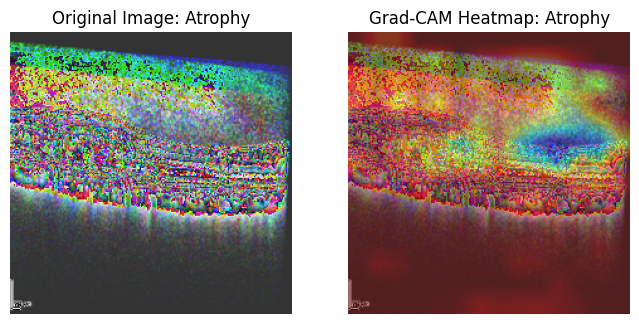

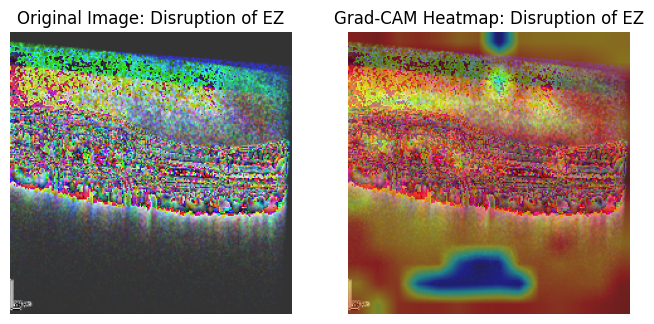

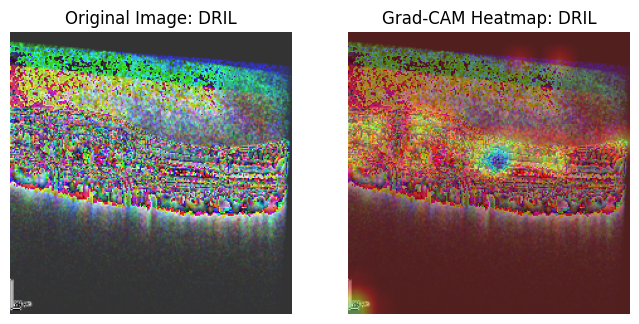

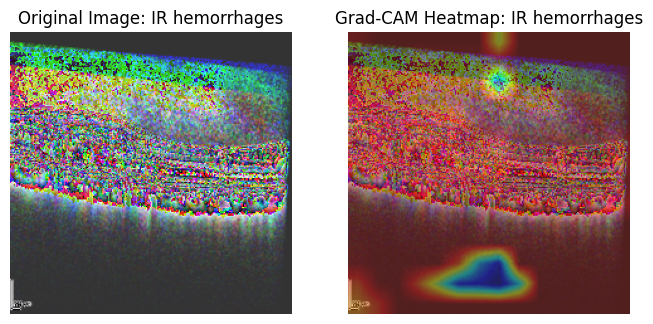

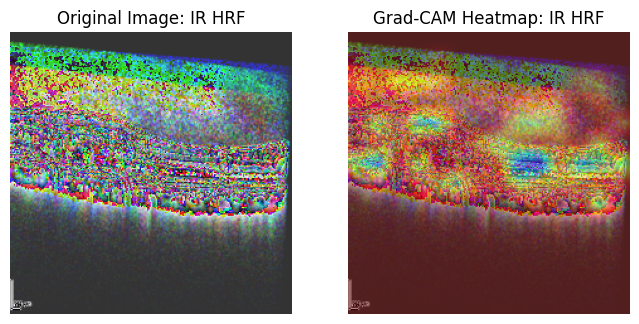

Visualizing Grad-CAM for Model without Clinical Data...


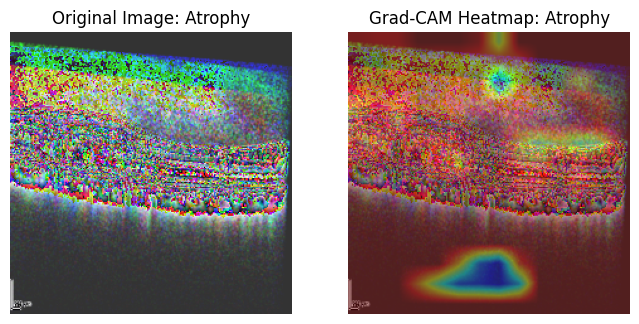

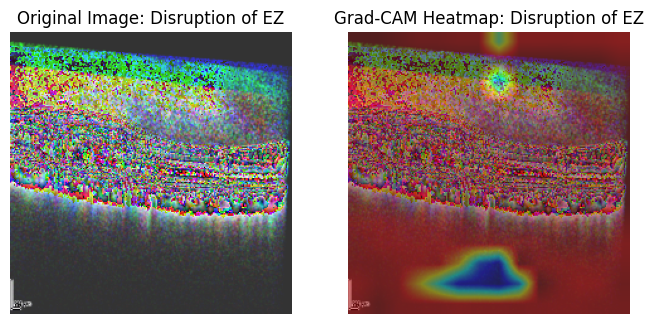

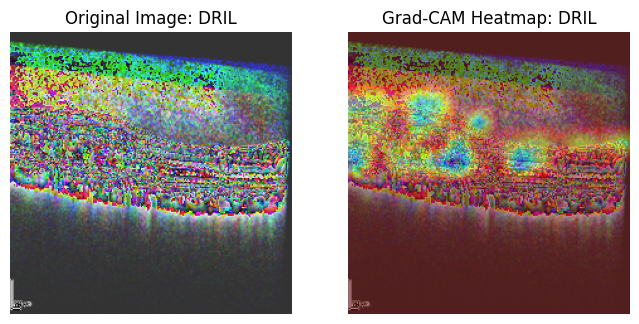

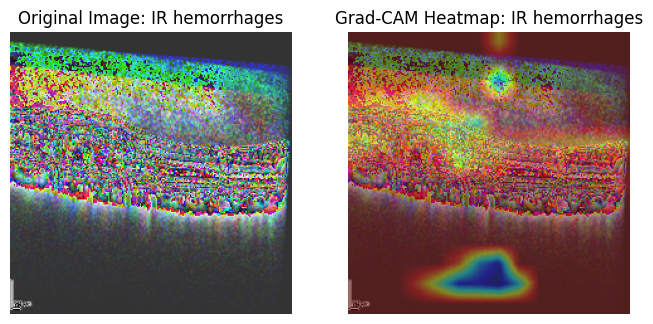

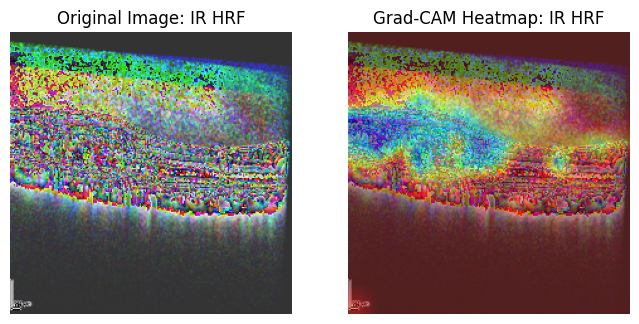

In [28]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from torchvision.transforms.functional import to_pil_image
from transformers import ViTForImageClassification
from PIL import Image
import torch.nn as nn


# Define Grad-CAM class
class GradCam:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Register hooks
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output  # Save activations

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]  # Save gradients

        # Find the target layer
        for name, module in self.model.named_modules():
            if name == self.target_layer:
                module.register_forward_hook(forward_hook)
                module.register_backward_hook(backward_hook)

    
    def generate(self, input_image, clinical_data=None, target_class=None):
        if clinical_data is None:
            clinical_data = torch.zeros((input_image.size(0), 2)).to(input_image.device)
    
    # Forward pass
        output = self.model(input_image, clinical_data)

    # Use the top predicted class if target_class is not specified
        if target_class is None:
            target_class = output.argmax(dim=1).item()

    # Backward pass
        self.model.zero_grad()
        class_score = output[0, target_class]
        class_score.backward()
 
    # Ensure gradients and activations are captured
        if self.gradients is None or self.activations is None:
            raise ValueError("Gradients or activations were not captured properly.")

    # Remove the class token (first token)
        activations = self.activations[:, 1:, :]  # Exclude class token
        gradients = self.gradients[:, 1:, :]  # Exclude class token

    # Grad-CAM for ViT: Weighted sum of patch embeddings
        weights = gradients.mean(dim=1)  # Average gradients across sequence dimension
        cam = torch.einsum("b d, b n d -> b n", weights, activations)  # Weighted sum

    # Reshape to 2D grid
        num_patches = int(cam.size(1)**0.5)
        cam = cam.view(cam.size(0), num_patches, num_patches)
        cam = torch.relu(cam).squeeze().detach().cpu().numpy()

    # Normalize to [0, 1]
        cam = (cam - cam.min()) / (cam.max() - cam.min())
        return cam

    def overlay_heatmap(self, heatmap, original_image, alpha=0.4):
        """
        Overlay the Grad-CAM heatmap on the original image.
        Args:
            heatmap (ndarray): Grad-CAM heatmap.
            original_image (PIL.Image or ndarray): Original image.
            alpha (float): Heatmap transparency.
        Returns:
            overlay (ndarray): Image with heatmap overlay.
        """
        # Resize heatmap to match the original image size
        heatmap = cv2.resize(heatmap, (original_image.size[0], original_image.size[1]))
        heatmap = np.uint8(255 * heatmap)  # Convert to uint8

        # Create heatmap image
        heatmap_img = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

        # Convert original image to OpenCV format
        original_image = np.array(original_image)
        if len(original_image.shape) == 2:  # Grayscale to RGB
            original_image = cv2.cvtColor(original_image, cv2.COLOR_GRAY2BGR)

        # Overlay heatmap
        overlay = cv2.addWeighted(original_image, 1 - alpha, heatmap_img, alpha, 0)
        return overlay


# Visualize Grad-CAM

def visualize_gradcam(model, gradcam, data_loader, labels, target_layer, num_samples=5, use_clinical=True):
    """
    Visualize Grad-CAM for a few samples from the data loader.
    Args:
        model (torch.nn.Module): The model to explain.
        gradcam (GradCam): Grad-CAM instance.
        data_loader (DataLoader): DataLoader with test images.
        labels (list): List of biomarker labels.
        target_layer (str): Target layer for Grad-CAM.
        num_samples (int): Number of samples to visualize.
        use_clinical (bool): Whether the model uses clinical data.
    """
    model.eval()
    count = 0
    for images, _, clinical_data in data_loader:
        images = images.to(device)
        clinical_data = clinical_data.to(device) if use_clinical else None

        for i in range(images.size(0)):
            input_image = images[i].unsqueeze(0)  # Single image
            input_clinical = clinical_data[i].unsqueeze(0) if clinical_data is not None else None
            original_image = to_pil_image(input_image.squeeze(0).cpu())  # Convert to PIL image

            for label_idx, label_name in enumerate(labels):
                # Generate Grad-CAM heatmap
                heatmap = gradcam.generate(input_image, clinical_data=input_clinical, target_class=label_idx)

                # Overlay heatmap on the original image
                overlay = gradcam.overlay_heatmap(heatmap, original_image)

                # Plot
                plt.figure(figsize=(8, 4))
                plt.subplot(1, 2, 1)
                plt.title(f"Original Image: {label_name}")
                plt.imshow(original_image, cmap="gray")
                plt.axis("off")

                plt.subplot(1, 2, 2)
                plt.title(f"Grad-CAM Heatmap: {label_name}")
                plt.imshow(overlay)
                plt.axis("off")

                plt.show()
                


                count += 1
                if count >= num_samples:
                    return
        break  # Visualize only the first batch


# Define target layer and Grad-CAM
target_layer = "vision_model.vit.encoder.layer.8.output"  # Change based on your ViT architecture

# Load trained models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vision_model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224", num_labels=16, ignore_mismatched_sizes=True
)
vision_model.classifier = nn.Identity()

# Load models with and without clinical data
model_clinical = MultimodalBiomarkerModel(vision_model, clinical_input_size=2, num_biomarkers=16, use_clinical=True).to(device)
model_no_clinical = MultimodalBiomarkerModel(vision_model, clinical_input_size=2, num_biomarkers=16, use_clinical=False).to(device)
model_clinical.load_state_dict(torch.load("best_model_clinical.pth"))
model_no_clinical.load_state_dict(torch.load("best_model_no_clinical.pth"))

# Initialize Grad-CAM
gradcam_clinical = GradCam(model_clinical, target_layer)
gradcam_no_clinical = GradCam(model_no_clinical, target_layer)

# Biomarker labels
labels = [
    "Atrophy", "Disruption of EZ", "DRIL", "IR hemorrhages", "IR HRF",
    "Partially attached vitreous face", "Fully attached vitreous face",
    "Preretinal tissue/hemorrhage", "Vitreous debris", "VMT", "DRT/ME", "Fluid (IRF)",
    "Fluid (SRF)", "Disruption of RPE", "PED (serous)", "SHRM"
]

print("Visualizing Grad-CAM for Model with Clinical Data...")
visualize_gradcam(model_clinical, gradcam_clinical, testloader_clinical, labels, target_layer, use_clinical=True)

print("Visualizing Grad-CAM for Model without Clinical Data...")
visualize_gradcam(model_no_clinical, gradcam_no_clinical, testloader_no_clinical, labels, target_layer, use_clinical=False)


In [21]:
for name, module in model_no_clinical.named_modules():
    print(name)


vision_model
vision_model.vit
vision_model.vit.embeddings
vision_model.vit.embeddings.patch_embeddings
vision_model.vit.embeddings.patch_embeddings.projection
vision_model.vit.embeddings.dropout
vision_model.vit.encoder
vision_model.vit.encoder.layer
vision_model.vit.encoder.layer.0
vision_model.vit.encoder.layer.0.attention
vision_model.vit.encoder.layer.0.attention.attention
vision_model.vit.encoder.layer.0.attention.attention.query
vision_model.vit.encoder.layer.0.attention.attention.key
vision_model.vit.encoder.layer.0.attention.attention.value
vision_model.vit.encoder.layer.0.attention.attention.dropout
vision_model.vit.encoder.layer.0.attention.output
vision_model.vit.encoder.layer.0.attention.output.dense
vision_model.vit.encoder.layer.0.attention.output.dropout
vision_model.vit.encoder.layer.0.intermediate
vision_model.vit.encoder.layer.0.intermediate.dense
vision_model.vit.encoder.layer.0.intermediate.intermediate_act_fn
vision_model.vit.encoder.layer.0.output
vision_model.vi